In [1]:
import sys, os
import ROOT
from pprint import pprint
from glob import glob
from CMS_lumi import CMS_lumi

ROOT.gROOT.LoadMacro("../interface/tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")

Welcome to JupyROOT 6.24/02


0

In [ ]:
ROOT.gInterpreter.ProcessLine(""" #include "../interface/EnRegression_Signal.h" """)

In [3]:
ROOT.EnableImplicitMT(20)
sigfiles = glob("../../GenStudy/miniTree/*/miniTree_HDalitz_ggF_eeg_125_*.root") 
pprint(sigfiles)
rdf = ROOT.RDataFrame("miniTree", sigfiles).Filter("category == 2") # Merged-2Gsf

['../../GenStudy/miniTree/UL2016preVFP/miniTree_HDalitz_ggF_eeg_125_UL2016preVFP.root',
 '../../GenStudy/miniTree/UL2018/miniTree_HDalitz_ggF_eeg_125_UL2018.root',
 '../../GenStudy/miniTree/UL2016postVFP/miniTree_HDalitz_ggF_eeg_125_UL2016postVFP.root',
 '../../GenStudy/miniTree/UL2017/miniTree_HDalitz_ggF_eeg_125_UL2017.root']


In [4]:
rdf_reg = ROOT.doEnRegression(ROOT.RDF.AsRNode(rdf), "eleHDALRegPt_Lead")

In [5]:
region = "EB"
# filter = "abs(eleSCEta_Lead) < 1.4442" if "EB" in region else "abs(eleSCEta_Lead) > 1.566 && abs(eleSCEta_Lead) < 2.5"
rdf_reg_EB = rdf_reg.Filter("abs(eleSCEta_Lead) < 1.4442")\
                    .Define("eleHDALRegPt_Lead", "electron_regression[\"DNN\"]")\
                    .Define("RecoEleReg_Lead", "ROOT::Math::PtEtaPhiMVector v(eleHDALRegPt_Lead, RecoEle_Lead.Eta(), RecoEle_Lead.Phi(), RecoEle_Lead.M()); return v;")\
                    .Define("RecoEleOri_Lead", "ROOT::Math::PtEtaPhiMVector v(eleCalibPt_Lead, RecoEle_Lead.Eta(), RecoEle_Lead.Phi(), RecoEle_Lead.M()); return v;")\
                    .Define("higgsMass_NEW", "(RecoEleReg_Lead + RecoPho_Lead).M()")\
                    .Define("higgsMass_OLD", "(RecoEleOri_Lead + RecoPho_Lead).M()")
                     
h_new_EB = rdf_reg_EB.Histo1D(("h_new_EB", "h_new_EB", 90, 110, 140), "higgsMass_NEW", "wei").GetPtr()
h_EB = rdf_reg_EB.Histo1D(("h_EB", "h_EB", 90, 110, 140), "higgsMass_OLD", "wei").GetPtr()

In [12]:
effsig_new = getEffSigma(h_new_EB)
effsig = getEffSigma(h_EB)

print("Before energy correction (EB): sigma = {:.4f}".format(effsig))
print("After energy correction  (EE): sigma = {:.4f}".format(effsig_new))

Before energy correction: sigma = 5.0930
After energy correction: sigma = 4.7462


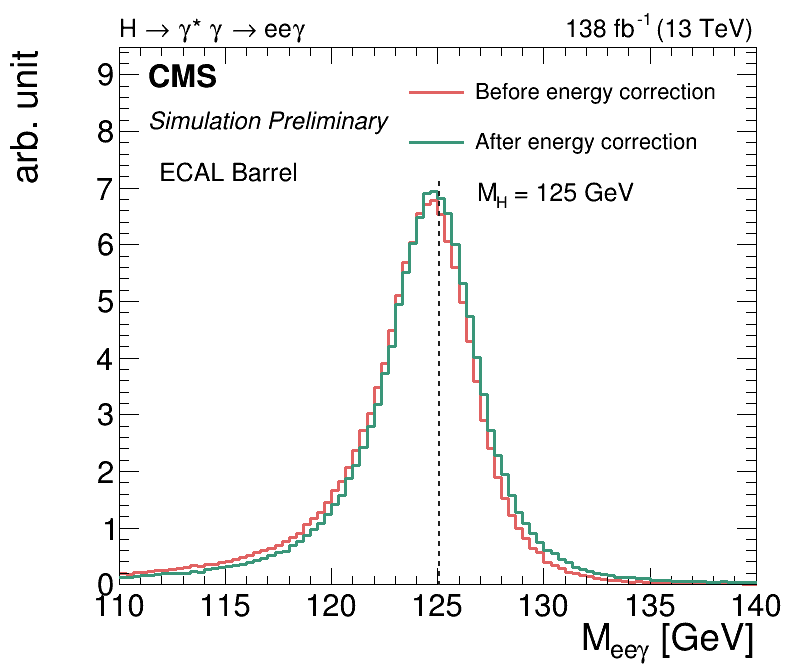

In [8]:
h_new_EB.Scale(1./h_new_EB.Integral(-1, -1))
h_EB.Scale(1./h_EB.Integral(-1, -1))

c = ROOT.TCanvas("c", "", 800, 700)
c.cd()
c.SetRigh_EBtMargin(0.05)
c.SetTopMargin(0.07)
c.SetLeftMargin(0.15)
c.SetBottomMargin(0.13)

h_EB.GetXaxis().SetTitle("M_{ee#gamma} [GeV]")
h_EB.GetYaxis().SetTitle("arb. unit")
h_EB.GetYaxis().SetRangeUser(0, h_EB.GetBinContent(h_EB.GetMaximumBin()) * 1.4)

h_EB.SetLineColor(ROOT.TColor.GetColor("#E16262"))
h_EB.SetLineWidth(3)

h_new_EB.SetLineColor(ROOT.TColor.GetColor("#3A9679"))
h_new_EB.SetLineWidth(3)

h_EB.Draw("hist")
h_new_EB.Draw("hist same")

leg = ROOT.TLegend(0.5, 0.75, 0.89, 0.9)
leg.SetTextSize(0.035)
leg.AddEntry(h_EB, "Before energy correction", "l")
leg.AddEntry(h_new_EB, "After energy correction", "l")
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.Draw()

extral = "ECAL Barrel" if "EB" in region else "ECAL Endcap"
ltx = ROOT.TLatex()
ltx.SetNDC()
ltx.SetTextFont(42)
ltx.SetTextSize(0.04)
ltx.DrawLatex(0.2, 0.73, extral)

ltx.DrawLatex(0.6, 0.7, "M_{H} = 125 GeV")

ltx.DrawLatex(0.75, 0.65, "#sigma^{Before}_{eff} = %.4f GeV")
ltx.DrawLatex(0.75, 0.62, "#sigma^{After}_{eff} = %.4f GeV")

l = ROOT.TLine(125, 0, 125, h_EB.GetBinContent(h_EB.GetMaximumBin()) * 1.05)
l.SetLineStyle(7)
l.SetLineWidth(3)
l.SetLineColor(ROOT.TColor.GetColor("#202020"))
l.Draw()

CMS_lumi(c, 5, 10, "138 fb^{-1}", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")

c.Draw()